In [ ]:
# default_exp gbe.baseline_drinking.separate

# Factor analysis
Factor analyses require large sample sizes, which this study is perfect for.

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
ist = ist_scoring.get_oversampling_predicted_joint(df)[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
ist = ist.groupby('participant').mean()
ist.columns = ['ist_oversampling']

R[write to console]: Lade nötiges Paket: lme4

R[write to console]: Lade nötiges Paket: Matrix

R[write to console]: 
Attache Paket: ‘lmerTest’


R[write to console]: Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


R[write to console]: Das folgende Objekt ist maskiert ‘package:stats’:

    step




### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_perc_correct_predicted_sep_trial(df)[0]
wm = wm.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
wm = wm.groupby('participant').mean()
wm = wm.rename(columns={'perc_predicted_sep_trial_no_distractor_1': 'wm_no_1',
                       'perc_predicted_sep_trial_no_distractor_2': 'wm_no_2',
                       'perc_predicted_sep_trial_encoding_distractor': 'wm_encoding',
                       'perc_predicted_sep_trial_delayed_distractor':'wm_delayed'})

8 participants used an old version of the task in some of their sessions.  13 sessions (2.48%) were removed from the dataset.
6 sessions (1.17%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
rtt = rtt_scoring.get_perc_gamble_predicted_joint(df)[0]
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
rtt = rtt.groupby('participant').mean()
rtt = rtt.rename(columns={'perc_gamble_joint_win': 'rtt_win',
                       'perc_gamble_joint_loss': 'rtt_loss',
                       'perc_gamble_joint_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
sst = sst_scoring.get_ssrt_predicted_joint(df)[0]
sst = sst.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
sst = sst.groupby('participant').mean()
sst.columns = ['ssrt']

## Factor analysis
Using oblimin rotation similar to Eisenberg.

In [ ]:
#!pip install factor-analyzer
from factor_analyzer.factor_analyzer import FactorAnalyzer 
fa = FactorAnalyzer(rotation='oblimin')

In [ ]:
tasks = pd.concat([wm, -sst, rtt,ist],axis = 1)

### Bartlett's test

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(tasks.dropna())
chi_square_value, p_value

(661.1738270138899, 5.34033492968838e-116)

Passes.

### Kaiser-Meyer-Olkin test

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(tasks.dropna())
kmo_model

0.7783686044547107

The KMO value is good (although some authors argue it should be over .8).

### Choosing the number of factors

#### Three factor solution

In [ ]:
fa.fit(tasks.dropna())
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.13717001, 1.49883633, 1.11185932, 0.96815237, 0.67606349,
       0.4815617 , 0.43830736, 0.37819932, 0.3098501 ])

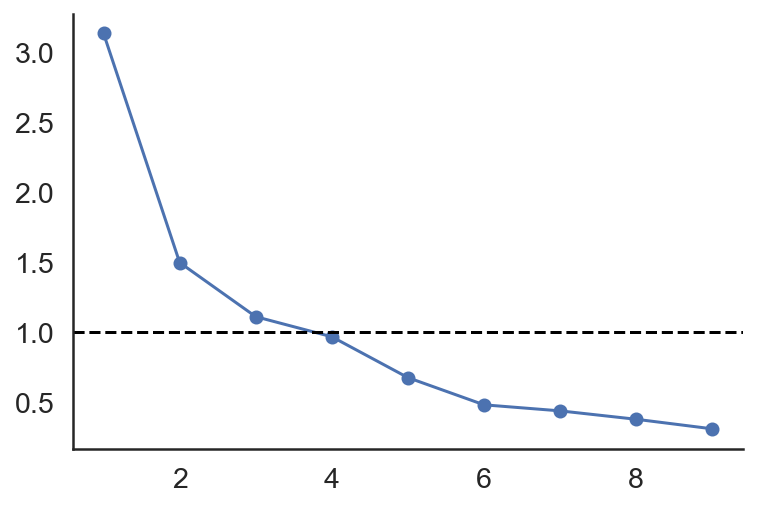

In [ ]:
plt.scatter(range(1, tasks.shape[1]+1),ev)
ax = plt.plot(range(1, tasks.shape[1]+1),ev)
plt.axhline(1, color = 'black', linestyle = '--')

In [ ]:
factors_3 = pd.DataFrame(fa.loadings_, columns = ['Factor 1','Factor 2','Factor 3'], index = tasks.columns)

In [ ]:
pd.DataFrame(fa.loadings_, columns = ['Factor 1','Factor 2','Factor 3'], index = tasks.columns)

,Factor 1,Factor 2,Factor 3
wm_no_2,0.794279,0.065466,0.032580
wm_no_1,0.778949,-0.041487,-0.003020
wm_encoding,0.739695,-0.037023,-0.115255
wm_delayed,0.816543,0.056089,0.029150
ssrt,0.478760,-0.155775,0.136097
rtt_win,0.080155,-0.174905,0.610367
rtt_loss,0.013903,0.995050,0.006815
rtt_mixed,-0.076963,0.198968,0.626569
ist_oversampling,-0.115855,-0.084862,-0.060199


In [ ]:
pd.DataFrame(fa.get_factor_variance(),columns = ['Factor 1','Factor 2','Factor 3'],index = ['SS Loadings','Proportion Var','Cumulative Var'])

,Factor 1,Factor 2,Factor 3
SS Loadings,2.706708,1.102296,0.802534
Proportion Var,0.300745,0.122477,0.089170
Cumulative Var,0.300745,0.423223,0.512393


51% of variance is explained by three factors.

#### Four factor solution

In [ ]:
fa = FactorAnalyzer(rotation='oblimin', n_factors = 4)
fa.fit(tasks.dropna())
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.13717001, 1.49883633, 1.11185932, 0.96815237, 0.67606349,
       0.4815617 , 0.43830736, 0.37819932, 0.3098501 ])

In [ ]:
pd.DataFrame(fa.loadings_, columns = ['Factor 1','Factor 2','Factor 3','Factor 4'], index = tasks.columns)

,Factor 1,Factor 2,Factor 3,Factor 4
wm_no_2,0.820191,0.032522,0.035121,0.063926
wm_no_1,0.737110,-0.012793,-0.024897,-0.131948
wm_encoding,0.705099,-0.012171,-0.129690,-0.087180
wm_delayed,0.854944,0.014444,0.036395,0.090818
ssrt,0.432566,-0.133931,0.118111,-0.169107
rtt_win,0.058729,-0.180787,0.557362,-0.141047
rtt_loss,0.010177,0.941570,0.015730,-0.012267
rtt_mixed,-0.033960,0.119159,0.726568,0.056578
ist_oversampling,-0.009827,-0.205581,-0.019400,0.362477


In [ ]:
factors_4 = pd.DataFrame(fa.loadings_, columns = ['Factor 1','Factor 2','Factor 3','Factor 4'], index = tasks.columns)

<AxesSubplot:>

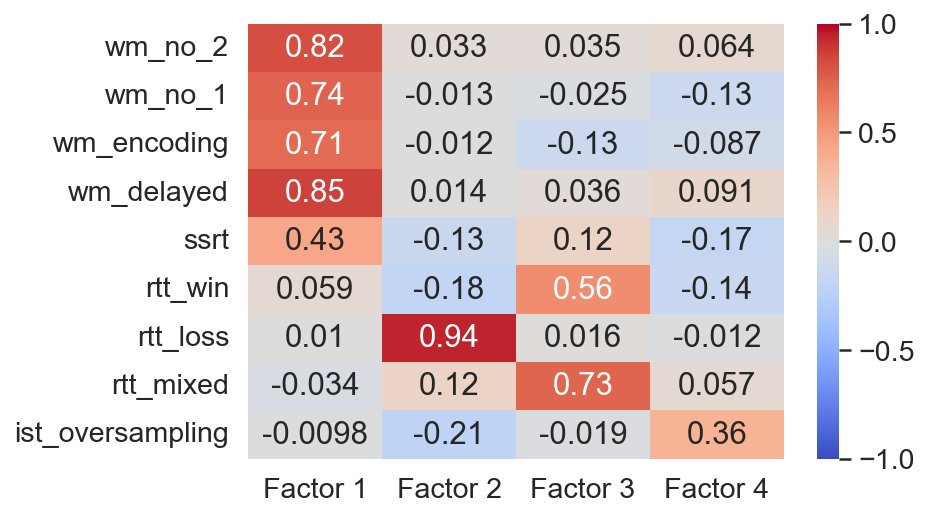

In [ ]:
sns.heatmap(factors_4, annot=True, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

In [ ]:
pd.DataFrame(fa.get_factor_variance(),columns = ['Factor 1','Factor 2','Factor 3','Factor 4'],index = ['SS Loadings','Proportion Var','Cumulative Var'])

,Factor 1,Factor 2,Factor 3,Factor 4
SS Loadings,2.636055,0.995216,0.873124,0.220578
Proportion Var,0.292895,0.110580,0.097014,0.024509
Cumulative Var,0.292895,0.403475,0.500488,0.524997


### Cluster analysis

..cutHeight not given, setting it to 1.1974170409470457  ===>  99% of the (truncated) height range in dendro.
..done.


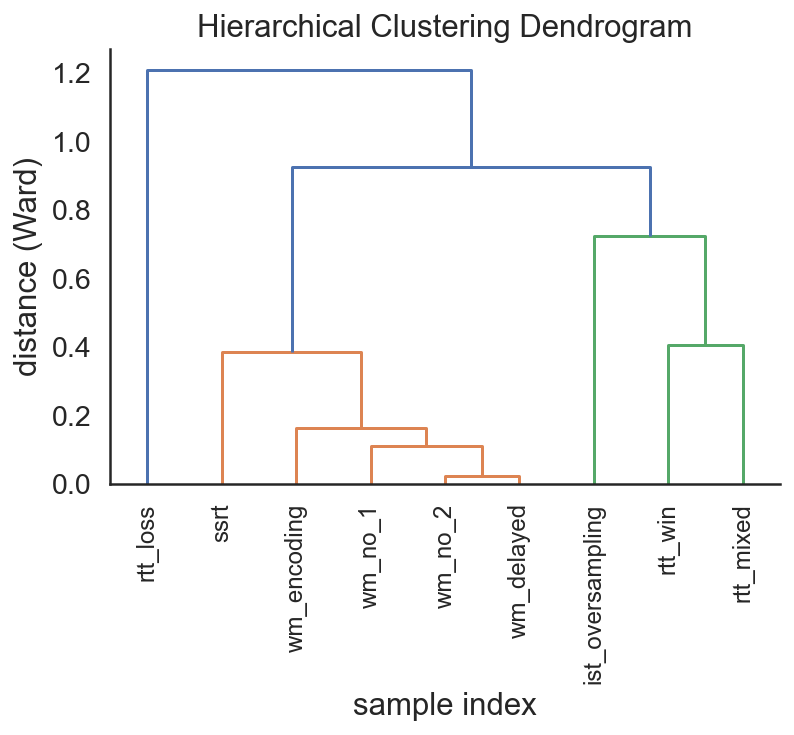

In [ ]:
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def dendo(df, distances = 'euclidean'):
    #d = np.transpose(np.arange(1,10001).reshape(100,100))
    d = df.values
    distances = pdist(d, distances) #euclidean
    link = linkage(distances, "average")
    clusters = cutreeHybrid(link, distances, minClusterSize = 3, pamStage = False)

    plt.title('Hierarchical Clustering Dendrogram')

# Plot axis labels
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')

# Make the dendrogram
    ax = dendrogram(link, labels=df.index, leaf_rotation=90)

# Show the graph
    plt.show()
    return ax
ax = dendo(factors_3, distances = 'euclidean')

..cutHeight not given, setting it to 1.0711837149364447  ===>  99% of the (truncated) height range in dendro.
..done.


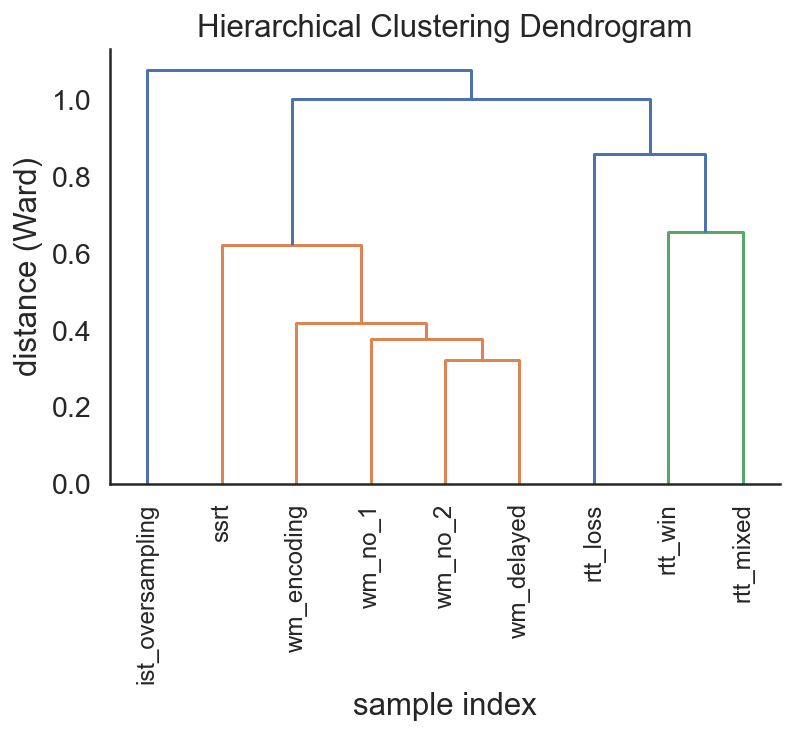

In [ ]:
ax = dendo(tasks.dropna().T,distances = 'correlation')

In [ ]:
ax['ivl']

['ist_oversampling',
 'ssrt',
 'wm_encoding',
 'wm_no_1',
 'wm_no_2',
 'wm_delayed',
 'rtt_loss',
 'rtt_win',
 'rtt_mixed']

<AxesSubplot:>

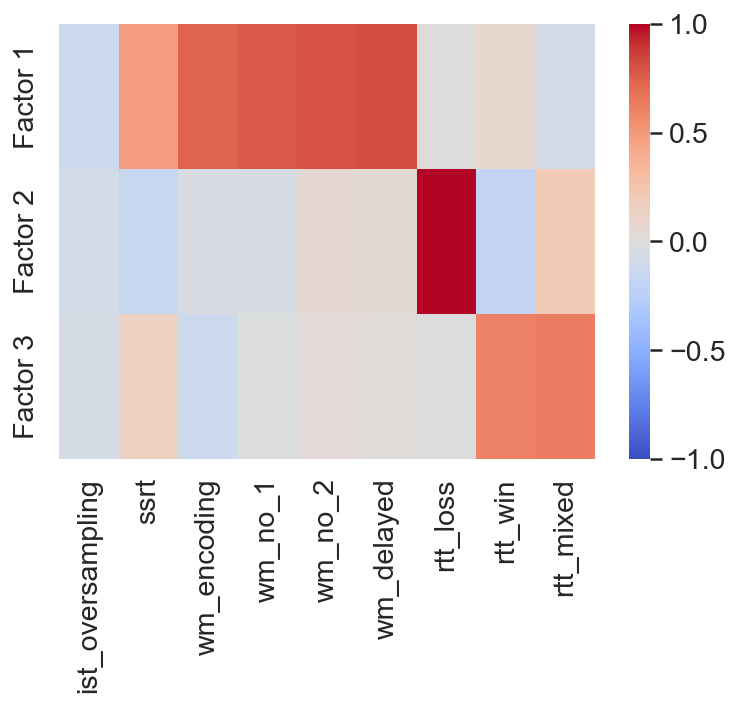

In [ ]:
sns.heatmap(factors_3.T[ax['ivl']], annot=False, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

..cutHeight not given, setting it to 1.1974170409470457  ===>  99% of the (truncated) height range in dendro.
..done.


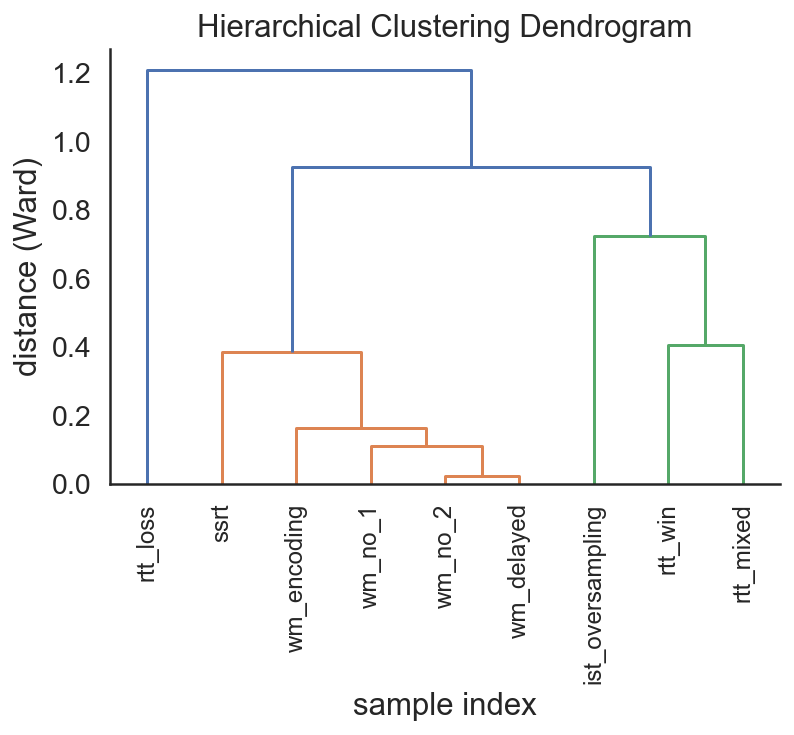

In [ ]:
df = factors_3

d = df.values
distances = pdist(d, "euclidean") #euclidean
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances, minClusterSize = 0)
plt.title('Hierarchical Clustering Dendrogram')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(link, labels=df.index, leaf_rotation=90)

# Show the graph
plt.show()

In [ ]:
r_data = tasks.dropna()

[1] "No module detected"


R[write to console]: Fehler in fviz_nbclust(x, pam, method = "silhouette") : 
  konnte Funktion "fviz_nbclust" nicht finden

R[write to console]: Zusätzlich: 
R[write to console]: Warnmeldungen:

R[write to console]: 1: 
R[write to console]: In cutreeDynamic(hc1) :
R[write to console]: 
 
R[write to console]:  cutreeDynamic: method "hybrid" requires a valid dissimilarity matrix "distM". 
Defaulting to method "tree".

R[write to console]: 2: 
R[write to console]: In cutreeDynamic(hc1) :
R[write to console]: 
 
R[write to console]:  cutreeDynamic: method "hybrid" requires a valid dissimilarity matrix "distM". 
Defaulting to method "tree".




Fehler in fviz_nbclust(x, pam, method = "silhouette") : 
  konnte Funktion "fviz_nbclust" nicht finden


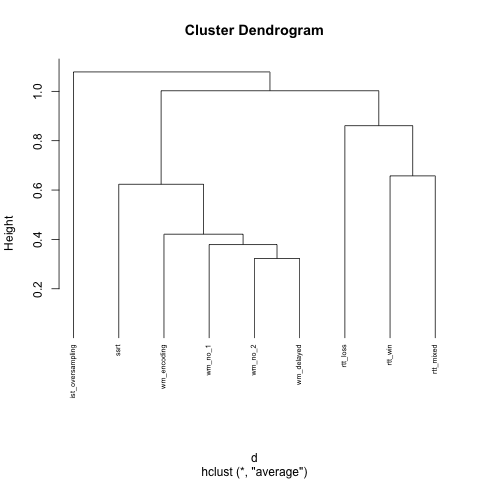

RInterpreterError: Failed to parse and evaluate line 'library(dynamicTreeCut)\nlibrary(psych)\nlibrary(amap)\n\nfit = fa(r_data, nfactors = 3, rotate = \'oblimin\')\nx <- fit$loadings#require = cutreeDynamic(link)\n\nd <- Dist(t(r_data), method = "correlation")\n# Hierarchical clustering using Complete Linkage\nhc1 <- hclust(d, method = "average" )\n# Plot the obtained dendrogram\nplot(hc1, cex = 0.6, hang = -1)\ncutreeDynamic(hc1)\nfviz_nbclust(x, pam, method = "silhouette")+ theme_classic()\n'.
R error message: 'Fehler in fviz_nbclust(x, pam, method = "silhouette") : \n  konnte Funktion "fviz_nbclust" nicht finden'

In [ ]:
%%R -i r_data
library(dynamicTreeCut)
library(psych)
library(amap)

fit = fa(r_data, nfactors = 3, rotate = 'oblimin')
x <- fit$loadings#require = cutreeDynamic(link)

d <- Dist(t(r_data), method = "correlation")
# Hierarchical clustering using Complete Linkage
hc1 <- hclust(d, method = "average" )
# Plot the obtained dendrogram
plot(hc1, cex = 0.6, hang = -1)
cutreeDynamic(hc1)
fviz_nbclust(x, pam, method = "silhouette")+ theme_classic()

<AxesSubplot:>

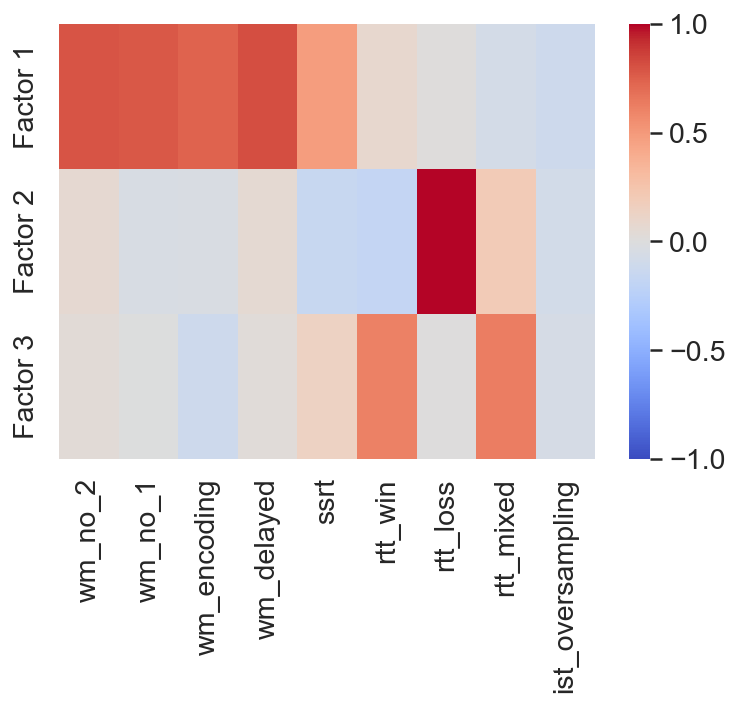

In [ ]:
sns.heatmap(factors_3.T, annot=False, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

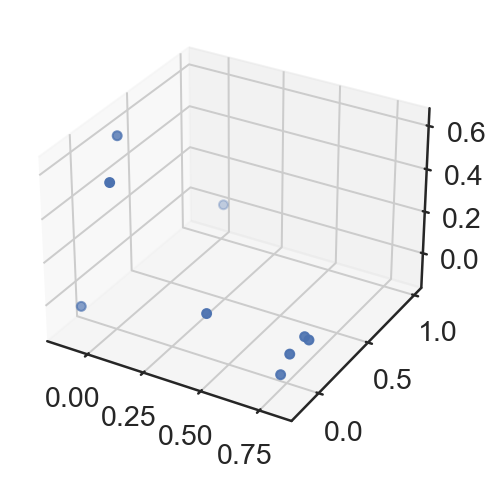

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(factors_3['Factor 1'], factors_3['Factor 2'], factors_3['Factor 3']);


In [ ]:
factors_3

,Factor 1,Factor 2,Factor 3
wm_no_2,0.794279,0.065466,0.032580
wm_no_1,0.778949,-0.041487,-0.003020
wm_encoding,0.739695,-0.037023,-0.115255
wm_delayed,0.816543,0.056089,0.029150
ssrt,0.478760,-0.155775,0.136097
rtt_win,0.080155,-0.174905,0.610367
rtt_loss,0.013903,0.995050,0.006815
rtt_mixed,-0.076963,0.198968,0.626569
ist_oversampling,-0.115855,-0.084862,-0.060199


### Factor scores
Factor scores calculated via the ten Berge method (for oblim rotation; Eisenberg; https://www.sciencedirect.com/science/article/pii/S0024379597100076; https://stackoverflow.com/questions/67856186/correct-way-to-calculate-correlations-between-factors).

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores


def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)

df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/psych/bfi.csv')
df = df.filter(regex='^A[1-5]|^N').copy()
df = df.fillna(df.median(0))

fa = FactorAnalyzer(n_factors=5, rotation=None).fit(df)
pd.DataFrame(ten_berge(df, fa.loadings_)).corr().round(3)

,0,1,2,3,4
0,1.0,-0.0,-0.0,-0.0,0.0
1,-0.0,1.0,-0.0,0.0,0.0
2,-0.0,-0.0,1.0,0.0,0.0
3,-0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0
